In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tqdm
import random

from SMPyBandits.Policies.Exp3S import Exp3S

from experiments.npe.model import get_npe_model
from experiments.npe.simulate import show_simulation
from renderer.threecircles import ThreeCircles
from experiments.playconf.environment import Environment, initialize_scene_from_configuration, make_training
from experiments.playconf.rl import get_actor, get_experience, get_critic, get_joint, get_random_experience, get_naive_adversarial_loss

Info: Using the Jupyter notebook version of the tqdm() decorator, tqdm_notebook() ...
pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html
Loading chipmunk for Linux (64bit) [/home/shreyask/anaconda3/envs/tensorflow2/lib/python3.7/site-packages/pymunk/libchipmunk.so]


In [2]:
with open('data/threecircles_munk_million_complexities.npe', 'rb') as f:
    data = pickle.load(f)

train_x, train_y, train_complex = data['train']
val_x, val_y = data['val']

train_x = np.array(train_x)
train_y = np.array(train_y)
train_complex = np.array(train_complex)

val_x = np.array(val_x)
val_y = np.array(val_y)

def breakdown(X):
    return [
        np.array([x[0] for x in X]),
        np.array([x[1] for x in X]),
        np.array([x[2] for x in X]),
        np.array([x[3] for x in X]),
        np.array([x[4] for x in X]),
    ]

In [3]:
unique, counts = np.unique(train_complex, return_counts=True)

np.asarray((unique, counts)).T

array([[     0, 641597],
       [     1, 198106],
       [     2,  27392],
       [     3,  91160],
       [     4,  28176],
       [     5,   5056],
       [     6,   5350],
       [     7,   2002],
       [     8,    409],
       [     9,    398],
       [    10,    253],
       [    11,     66],
       [    12,      5],
       [    13,     24],
       [    14,      4],
       [    15,      1],
       [    16,      1]])

In [5]:
num_arms = 10

def sample_arm(arm_index, batch_size):
    sub_indexes = np.nonzero(train_complex == arm_index)[0]
    sample_indexes = np.random.choice(sub_indexes, batch_size)
    
    return train_x[sample_indexes], train_y[sample_indexes]

def sample_random(batch_size):
    sample_indexes = np.random.choice(len(train_x), batch_size)
    
    return train_x[sample_indexes], train_y[sample_indexes]

def sample_random_val(batch_size):
    sample_indexes = np.random.choice(len(val_x), batch_size)
    
    return val_x[sample_indexes], val_y[sample_indexes]

def sample_random_td(x, y, batch_size):
    sample_indexes = np.random.choice(len(x), batch_size)
    
    return x[sample_indexes], y[sample_indexes]

In [6]:
x, y = sample_random_td(train_x, train_y, 100000)

b_train_x = breakdown(x)
b_val_x = breakdown(val_x)

model = get_npe_model(max_pairs=2)

opt = tf.keras.optimizers.RMSprop(learning_rate=0.0003)
model.compile(loss="mse", optimizer=opt)

history_baseline = model.fit(
    b_train_x,
    y,
    validation_data=(b_val_x, np.array(val_y)),
    epochs=10,
    batch_size=50,
)

Train on 100000 samples, validate on 10000 samples
Epoch 1/10
100000/100000 [==============================] - 27s 271us/sample - loss: 0.0145 - val_loss: 0.0124
Epoch 2/10
100000/100000 [==============================] - 25s 246us/sample - loss: 0.0094 - val_loss: 0.0083
Epoch 3/10
100000/100000 [==============================] - 25s 245us/sample - loss: 0.0081 - val_loss: 0.0065
Epoch 4/10
100000/100000 [==============================] - 25s 248us/sample - loss: 0.0073 - val_loss: 0.0064
Epoch 5/10
100000/100000 [==============================] - 25s 249us/sample - loss: 0.0066 - val_loss: 0.0056
Epoch 6/10
100000/100000 [==============================] - 25s 249us/sample - loss: 0.0061 - val_loss: 0.0056
Epoch 7/10
100000/100000 [==============================] - 25s 248us/sample - loss: 0.0058 - val_loss: 0.0052
Epoch 8/10
100000/100000 [==============================] - 25s 250us/sample - loss: 0.0056 - val_loss: 0.0057
Epoch 9/10
100000/100000 [==============================] - 2

In [17]:
model = get_npe_model(max_pairs=2)

opt = tf.keras.optimizers.RMSprop(learning_rate=0.0003)
model.compile(loss="mse", optimizer=opt)

h = []

In [34]:
# epoch_arm = [
#     [0], [0, 1], [0, 1, 2], [1, 2, 3], [3, 4], [3, 4, 5], [3, 4, 5], [3, 4, 5], [3, 4, 5], [3, 4, 5], [3, 4, 5]
# ]

# for epoch in range(10):
selected_x = train_x[(train_complex == 2) | (train_complex == 3) | (train_complex == 4)]
selected_y = train_y[(train_complex == 2) | (train_complex == 3) | (train_complex == 4)]
x, y = sample_random_td(selected_x, selected_y, 100000)

b_train_x = breakdown(x)
b_val_x = breakdown(val_x)

h.append(model.fit(
    b_train_x,
    y,
    validation_data=(b_val_x, np.array(val_y)),
    epochs=1,
    batch_size=50,
))

Train on 100000 samples, validate on 10000 samples
100000/100000 [==============================] - 25s 245us/sample - loss: 0.0123 - val_loss: 0.0046


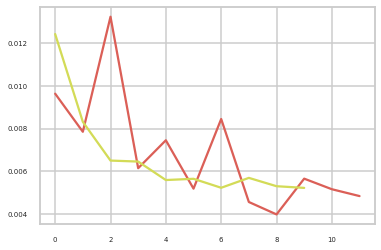

In [33]:
plt.plot([hh.history['val_loss'] for hh in h])
plt.plot(history_baseline.history['val_loss'])

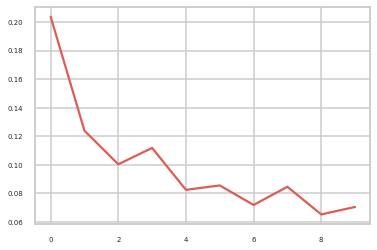

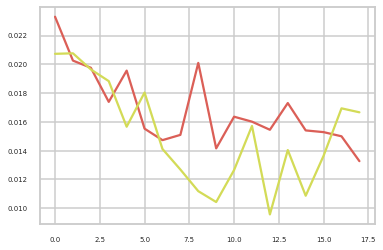

Iteration: 1700, Baseline: 0.013272, Bandit: 0.016666


KeyboardInterrupt: 

In [6]:
model_baseline = get_npe_model(max_pairs = 2)
model_bandit = get_npe_model(max_pairs = 2)

model_baseline.compile(loss='mse', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0003))
model_bandit.compile(loss='mse', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0003))

bandit = Exp3S(num_arms, gamma=0.05)

batch_size = 32
iterations = 100000
validate_every = 100

baseline_losses = []
bandit_losses = []
pgs = []

a = []
b = []

pbar = tqdm.tqdm_notebook(range(iterations))

for iteration in pbar:
    pbar.refresh()
    if iteration % validate_every == 0:
        baseline_loss = model_baseline.evaluate(breakdown(val_x), val_y, verbose=0)
        bandit_loss = model_bandit.evaluate(breakdown(val_x), val_y, verbose=0)
        
        baseline_losses.append(baseline_loss)
        bandit_losses.append(bandit_loss)
        
        from IPython.display import clear_output
        clear_output(wait=True)
        plt.figure(0)
        plt.plot(bandit.trusts)
        plt.figure(1)
        plt.plot(baseline_losses)
        plt.plot(bandit_losses)
        plt.show()
        
        print('Iteration: %i, Baseline: %f, Bandit: %f' % (iteration, baseline_loss, bandit_loss))
        
    # Train baseline.
    #x, y = sample_arm(random.randint(0, num_arms-1), batch_size)
    x, y = sample_random(batch_size)
    baseline_history = model_baseline.fit(breakdown(x), y, epochs=1, batch_size=batch_size, verbose=0)
    
    # Train bandit.
    current_arm = bandit.choice()
    x, y = sample_arm(current_arm, batch_size)
    bx = breakdown(x)
    
    vx, vy = sample_random_val(512)
    bvx = breakdown(vx)
    
    loss_before = model_bandit.evaluate(bvx, vy, verbose=0)
    bandit_history = model_bandit.fit(bx, y, epochs=1, batch_size=batch_size, verbose=0)
    loss_after = model_bandit.evaluate(bvx, vy, verbose=0)
    
    pg = (loss_before - loss_after)
    
    if len(pgs) < 5:
        r = 0.0
    else:
        q_u = np.percentile(pgs, 80)
        q_l = np.percentile(pgs, 20)

        if pg > q_u:
            r = 1.0
        elif pg < q_l:
            r = -1.0
        else:
            r = 2.0 * (pg - q_l) / (q_u - q_l) - 1.0
        
    pgs.append(pg)
    
    bandit.getReward(current_arm, r)

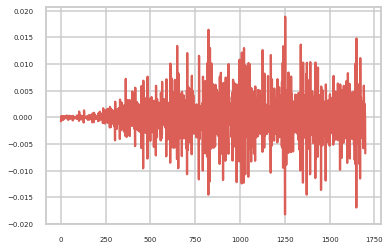

In [7]:
plt.plot(pgs)

In [15]:
from scipy.interpolate import interpn

def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins)
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False )

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )
    return ax

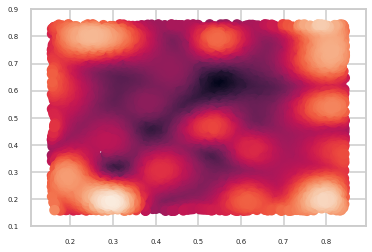

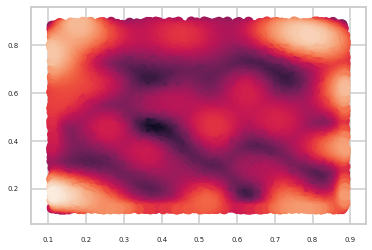

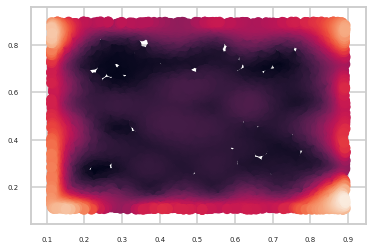

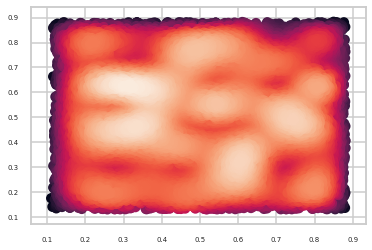

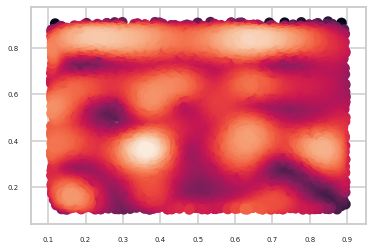

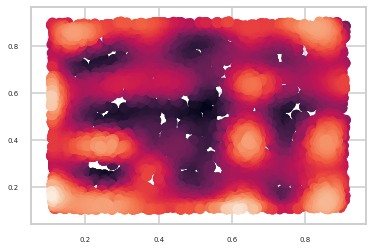

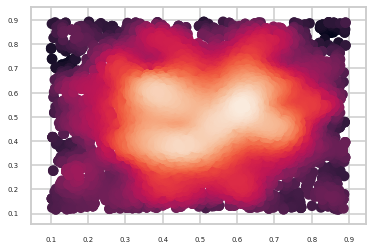

In [31]:
for arm in range(7):
    px = []
    py = []

    x, y = sample_arm(arm, 10000)

    for t in range(len(x)):
        points_p = np.array([x[t][i][:2] for i in range(3)])
        points_n = np.array([x[t][i][2:] for i in range(3)])

    #     plt.scatter(points_p[:, 0], points_p[:, 1])
    #     plt.scatter(points_n[:, 0], points_n[:, 1])
    #     plt.scatter([x[t][0][2:][0] + y[t][0] * 1/10.0], [x[t][0][2:][1] + y[t][1] * 1/10.0])


        # Position
#         px.append(x[t][0][2:][0] + y[t][0] * 1/10.0)
#         py.append(x[t][0][2:][1] + y[t][1] * 1/10.0)

    
        px.append(points_p[0][0])
        py.append(points_p[0][1])

    density_scatter(np.array(px), np.array(py), bins=10)